In [7]:
import tensorflow as tf


import cv2
import os
import matplotlib.pyplot as plt
import sys

import os.path as pth
from tqdm import tqdm
#import tqdm
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        
        tf.config.experimental.set_memory_growth(gpus[0], True)
        
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=15000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [ ]:
pip install tqdm

In [ ]:
# cv2.imshow를 대신하는 함수
# 반드시 먼저 실행

def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    return plt.imshow(a, **kwargs)

# 1. 이미지 얼굴만 크롭

## 1-1. 얼굴 크롭하기

In [ ]:

img_list = list()


face_cascade = cv2.CascadeClassifier('./data/haarcascade_frontface.xml')
eye_casecade = cv2.CascadeClassifier('../haarcascades/haarcascade_eye.xml')



for name in os.listdir('./data/emotion_img'):
    img_list.append(name)
    

    img = cv2.imread('./data/emotion_img/' + name)
    # print(img.shape)
    # (720, 1280, 3) -> 이미지 사이즈 1280*720, 컬러 이미지 
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    face = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    img_w = img.shape[1]
    img_h = img.shape[0]
        
    
    if (len(face)==0):
        print('face none or lengh is zero:' + name)
    
    
    else:
        
        for (x,y,w,h) in face:
            
            crop_point_y = y - int(h/4)
            crop_len_h = y + h + int(h/4)
            crop_point_x = x - int(w/4)
            crop_len_w = x + w + int(w/4)
            
            if crop_point_y < 0: 
                crop_point_y = 0
                
            if crop_point_x < 0:
                crop_point_x = 0
            
            if crop_len_h > img_h:
                crop_len_h = img_h
            
            if crop_len_w > img_w:
                crop_len_w = img_w

            cropped = img[crop_point_y:crop_len_h, crop_point_x:crop_len_w]
            
            
            try:
                cv2.imwrite('./data/cropped_img/%s' %name, cropped)
            except:
                print("cv2 error")
                print("{}/{}/{}/{}".format(x,y,w,h))
                print(name)
                continue



            cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]



# cv2_imshow(cropped)
# cv2.waitKey(0)




## 1-2. 크롭한 사진 리사이징

In [29]:
from PIL import Image

# image = Image.open('./data/test2.jpg')

# resize_image = image.resize((600,600))

# resize_image.save('./data/test2_re.jpg')

for filename in os.listdir('./data/cropped_img'):
    filepath = './data/cropped_img' + '/' + filename
    
    image = Image.open(filepath)
    
    resize_image = image.resize((600,600))
    
    resize_image.save('./data/cropped_img_resize' +'/' + filename)
    
    

# 2. 데이터 불러오기

In [8]:
label_df = pd.read_excel('./data/categries_emo.xlsx')
label_dict = dict(label_df[['Num','Emotion']].values)


# 파일 제목에서 3번째 항목만 사용
print(label_df)

emotion_arr = label_df.loc[:,'Num'].values


emotion_list = emotion_arr.tolist()
#print(emotion_list)

label_dict[1]

   Num    Emotion
0    1    neutral
1    2       calm
2    3      happy
3    4        sad
4    5      angry
5    6    fearful
6    7    disgust
7    8  surprised


'neutral'

In [30]:
# 크롭한 이미지 파일의 경로 + 라벨링 df 생성

files = list()
categories = list()


for filename in os.listdir('./data/cropped_img_resize'):
    filepath = './data/cropped_img_resize' + '/' + filename
    files.append(filepath)
    
    emo = filename[7]
    
    for n in emo:
        categories.append(n)
        
cro_train_data = pd.DataFrame({'file':files,
                               'label':categories})
    

cro_train_data

label = cro_train_data.loc[:,'label'].values
emotion = list()

for n in label:
    emotion.append(label_dict[int(n)])
    
    
cro_train_data['emotion'] =emotion
cro_train_data

,file,label,emotion
0,./data/cropped_img_resize/02-01-07-02-01-02-12...,7,disgust
1,./data/cropped_img_resize/02-01-06-01-01-02-12...,6,fearful
2,./data/cropped_img_resize/02-01-08-01-02-02-12...,8,surprised
3,./data/cropped_img_resize/02-01-06-01-01-02-12...,6,fearful
4,./data/cropped_img_resize/02-01-08-01-01-01-12...,8,surprised
...,...,...,...
93926,./data/cropped_img_resize/02-01-01-01-01-01-02...,1,neutral
93927,./data/cropped_img_resize/02-01-02-02-02-01-06...,2,calm
93928,./data/cropped_img_resize/02-01-08-02-01-01-21...,8,surprised
93929,./data/cropped_img_resize/02-01-07-02-02-02-20...,7,disgust


# 3. TFrecord 생성

## 3-1. TFrecord 타입 변환 함수

In [31]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _validate_text(text):
    """If text is not str or unicode, then try to convert it to str."""
    if isinstance(text, str):
        return text
    elif isinstance(text, 'unicode'):
        return text.encode('utf8', 'ignore')
    else:
        return str(text)

## 3-2. TFrecord 변환 함수

In [32]:
def to_tfrecords(id_list, emotion_list, tfrecords_name):
    print("Start converting")
    options = tf.io.TFRecordOptions(compression_type = 'GZIP')
    with tf.io.TFRecordWriter(path=pth.join(tfrecords_name+'.tfrecords'), options=options) as writer:
        for id_, emotion_id in tqdm(zip(id_list, emotion_list), total=len(id_list), position=0, leave=True):
            image_path = pth.join(id_) # 불러올 이미지 위치 입력
            _binary_image = tf.io.read_file(image_path)
            
            # 타입 변환 함수 넣어서 타입 맞추기    
            string_set = tf.train.Example(features=tf.train.Features(feature={
                'image_raw': _bytes_feature(_binary_image),
                'img_id': _bytes_feature(emotion_id.encode()),
                'id': _bytes_feature(_validate_text(id_).encode()),
            }))

            writer.write(string_set.SerializeToString())   

In [33]:
# train, valid set 나누기
with tf.device('/device:GPU:0'):
    train_ids, val_ids, train_emotion_ids, val_emotion_ids = train_test_split(cro_train_data['file'], cro_train_data['label'], test_size=0.2, random_state=42, shuffle=True,
                                                                              stratify=cro_train_data['label'])
# 파일이 생성될 위치 지정
    to_tfrecords(train_ids, train_emotion_ids, pth.join('./data/emotion_crop_tf', 'tf_record_train'))
    to_tfrecords(val_ids, val_emotion_ids, pth.join('./data/emotion_crop_tf', 'tf_record_valid'))

  0%|          | 94/75144 [00:00<01:20, 933.25it/s]

Start converting


  0%|          | 93/18787 [00:00<00:20, 899.00it/s]

Start converting


100%|██████████| 18787/18787 [00:23<00:00, 814.41it/s]


# 4. TFrecord 테스트

In [34]:
train_tfrecord_path = pth.join('./data/emotion_crop_tf', 'tf_record_train.tfrecords')
valid_tfrecord_path = pth.join('./data/emotion_crop_tf', 'tf_record_valid.tfrecords')

BUFFER_SIZE = 256
BATCH_SIZE = 64
NUM_CLASS = 8

In [35]:
with tf.device('/device:GPU:0'):
    image_feature_description = {
        'image_raw': tf.io.FixedLenFeature([], tf.string),
        'img_id': tf.io.FixedLenFeature([], tf.string),
        # 'id': tf.io.FixedLenFeature([], tf.string),
    }



    def _parse_image_function(example_proto):
        return tf.io.parse_single_example(example_proto, image_feature_description)

    def map_func(target_record):
        img = target_record['image_raw']
        label = int(target_record['img_id'])
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.dtypes.cast(img, tf.float32)
        return img, label

    def prep_func(image, label):
        print(type(label))
            
        result_image = image / 255
        result_image = tf.image.resize(result_image, (224,224))
        
        onehot_label = tf.one_hot(label, depth=NUM_CLASS)
        return result_image, onehot_label

    
with tf.device('/device:GPU:0'):
    dataset = tf.data.TFRecordDataset(train_tfrecord_path, compression_type='GZIP')
    dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    valid_dataset = tf.data.TFRecordDataset(valid_tfrecord_path, compression_type='GZIP')
    valid_dataset = valid_dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.shuffle(BUFFER_SIZE)
    valid_dataset = valid_dataset.batch(BATCH_SIZE)
    valid_dataset = valid_dataset.map(prep_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


(64, 224, 224, 3) (64, 8)
sad


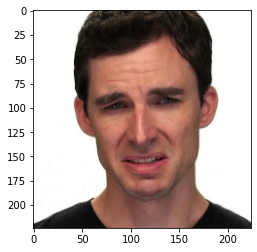

In [36]:
for batch_x, batch_y in dataset:
    print(batch_x.shape, batch_y.shape)
    
    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict[target_class])
    
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.show()
    
    break

(64, 224, 224, 3) (64, 8)
calm


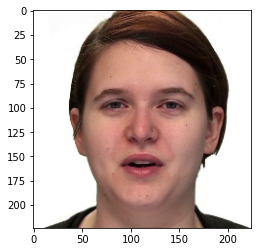

In [37]:
for batch_x, batch_y in valid_dataset:
    print(batch_x.shape, batch_y.shape)
    
    target_class = np.argmax(batch_y[0].numpy())
    print(label_dict[target_class])
    
    plt.figure()
    plt.imshow(batch_x[0].numpy())
    plt.show()
    
    break